In [3]:
# Objective is to link up the devon dataset with a PV system in the area
# start off with predicting PV based on image, not including time series aspect

# Potentially useful tutorial here https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed
# Illinois converting data to numpy https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb

### 1. Importing data

In [63]:
import numpy as np
import datetime
import pandas as pd
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from PIL import Image as im

In [5]:
# X: dataset            # cropped satellite image
# Y: devon_pv_df        # pv_yield

#### PV yield

In [3]:
pv_power = xr.open_dataset("data/uk_pv/pv.netcdf", engine="h5netcdf")
# PV yield is every 5 minutes, from 2018-01-01 to 2021-10-27, from 6am to 7pm

devon_pv_df = pv_power['6848'].to_dataframe()

# cropping for 2020-01-01 to 2021-11-07

devon_pv_df = devon_pv_df[devon_pv_df.index < '2020-12-30']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2020-01-01']

In [4]:
#devon_pv_df.drop(columns=1)
pv_times_list = devon_pv_df.index.tolist()
print('Number of PV readings :', len(pv_times_list))

Number of PV readings : 104532


#### Sat images

In [5]:
# I then cropped the satellite dataset using time-crop.ipnyb to get only PV images between 06:00 and 20:00

# sat_times: a numpy array of timestamps for PV data between 06:00 and 20:00
# pv_slices: a numpy array of PV data for the associated timestamps above

In [6]:
cropped_sat_times = np.load('data/sat_times_2020.npy')
cropped_sat_times_list = cropped_sat_times.tolist()
len(cropped_sat_times) # we have 50K sat_times

55787

In [7]:
# convert back to datetime format (since changed into int when converted into numpy)
cropped_sat_times_list[0]

for i in range(len(cropped_sat_times_list)):
    cropped_sat_times_list[i] = np.datetime64(cropped_sat_times_list[i],"ns")

In [8]:
# 1GB file
sat_data = np.load('data/sat_slices_2020.npy')

In [9]:
print(sat_data.shape)

(55787, 100, 100)


In [10]:
sat_data[1]

array([[13, 12, 12, ..., 12, 12, 12],
       [13, 12, 12, ..., 12, 13, 13],
       [12, 13, 12, ..., 15, 12, 12],
       ...,
       [12, 12, 13, ..., 12, 12, 12],
       [12, 12, 13, ..., 13, 13, 12],
       [12, 12, 12, ..., 12, 12, 13]], dtype=int16)

In [11]:
print(cropped_sat_times_list[0])

2020-01-01T06:00:00.000000000


#### Do we have PV readings for all sat images?

In [15]:
# So we have 54K satellite images
# We have 100K PV data readings

# There will be lots of PV data readings to drop, because they'll be outside the range
# We should loop through PV data readings, and if there's a satellite image, add it to an array

In [12]:
len(pv_times_list)

104532

In [222]:
# Create a dataset where the timestamp is the same between both

pv_readings = []
sat_images = []

for time in tqdm.tqdm(pv_times_list[:50000]):
    if time in cropped_sat_times_list[:50000]:
        # Add the PV reading for that time
        pv_readings.append(devon_pv_df[devon_pv_df.index == time])
        
        # Add the satellite image 
        
        # Find which observation relates to this timestamp
        sat_obs_number = cropped_sat_times_list[:10000].index(time)
        sat_images.append(sat_data[sat_obs_number])



  0%|          | 69/50000 [00:09<1:55:01,  7.23it/s]


KeyboardInterrupt: 

In [177]:
np.save('data/sat_images_2020_devon_timecropped_scaled', sat_images)
np.save('data/pv_yield_2020_devon_timecropped', pv_readings)

In [178]:
# Just took the first 10,000 from each list, it was taking a long time otherwise

print(len(pv_readings))
print(len(sat_images))

1163
1163


In [184]:
max(pv_readings_array.flatten())

1831.944

In [186]:
# The inputs are both lists of arrays, should I convert them to arrays?

pv_readings_array = np.asarray(pv_readings)
pv_readings_array = pv_readings_array.flatten()
print(len(pv_readings))
pv_readings_scaled = pv_readings_array / (max(pv_readings_array) +1) # scaling the PV, making this slightly bigger so range is between 0 and 1

# Scale images down by dividing by 255
sat_images = np.asarray(sat_images)
sat_images_scaled = sat_images / 255

 


1163


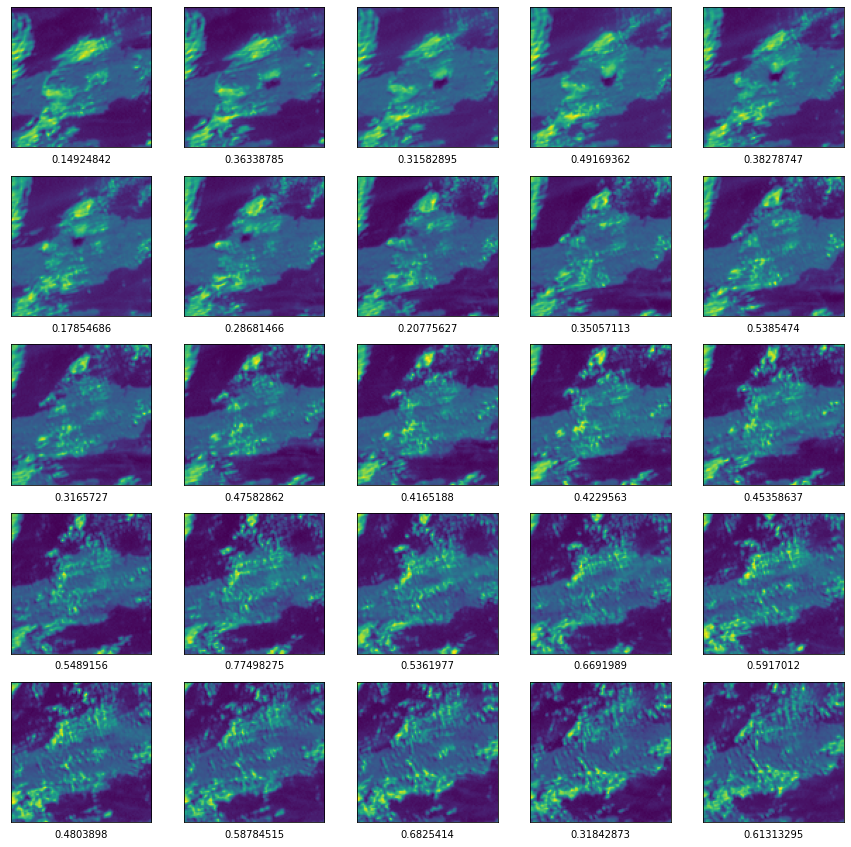

In [188]:
# Comparing PV measurements, matched with images

plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sat_images_scaled[i+400])
    plt.xlabel(pv_readings_scaled[i+400])
plt.show()

#### Training a model 

In [189]:
# Inputs to this section

print(len(pv_readings_scaled))
print(len(sat_images_scaled)) # (in this case scaled means /255)

1163
1163


In [193]:
# Dropping examples where PV yield is zero - making a copy to be safe

drop_pv_readings = []
drop_sat_images_scaled = []

i = 0
for i in range(len(pv_readings_scaled)):
    if pv_readings_scaled[i] > 0.001:
        drop_pv_readings.append(pv_readings_scaled[i])
        drop_sat_images_scaled.append(sat_images_scaled[i])

In [194]:
print(len(drop_pv_readings))
print(len(drop_sat_images_scaled)) # (in this case scaled means /255)

624
624


In [196]:
# Think I need to resize the images

def scale(array):
    X_resized = []

    for i in range(len(array)):
        image = Image.fromarray(array[i])
        image_resized = image.resize((32,32))
    
        X_resized.append(np.array(image_resized))

    return np.array(X_resized)

In [197]:
X_resized = scale(drop_sat_images_scaled)
print(np.array(X_resized).shape)

(624, 32, 32)


In [198]:

print('Size of X array :', np.array(X_resized).shape)
print('Size of y array :', len(drop_pv_readings))

X = X_resized
y = np.array(drop_pv_readings)

Size of X array : (624, 32, 32)
Size of y array : 624


In [199]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=42)

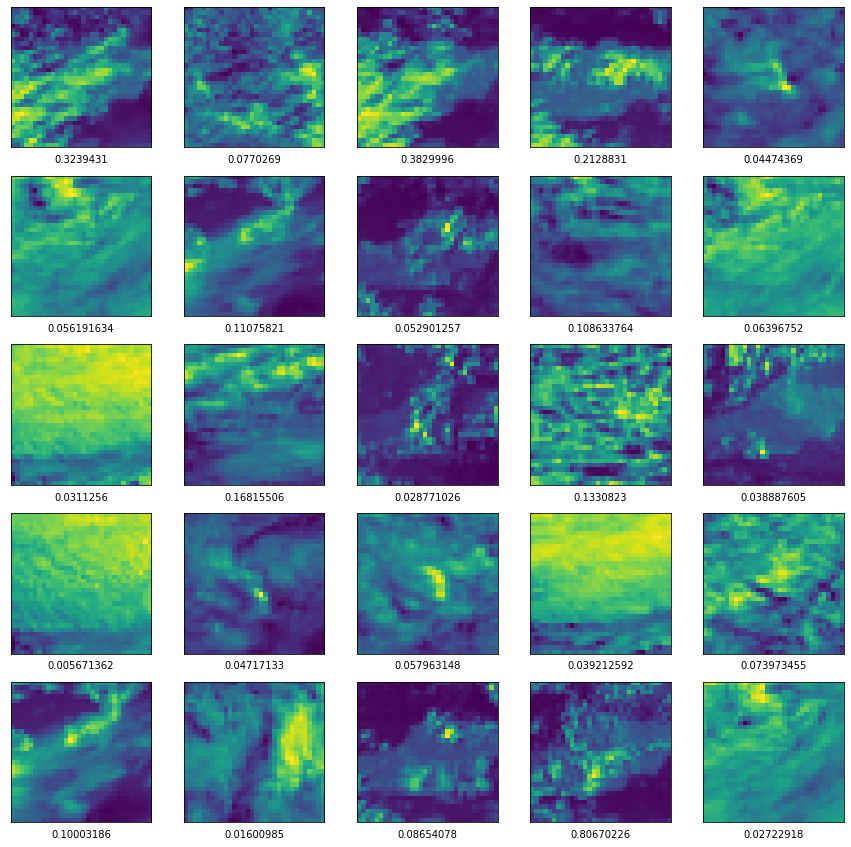

In [200]:
# Getting quite a few where image is distorted - suspect this is when datafeed is offline

plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+100])
    plt.xlabel(train_labels[i+100])
plt.show()

In [215]:
# tf tutorial https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
import keras

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

In [218]:
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

# Changed from 10 epochs down to 5

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

                    

Epoch 1/10
15/15 [==============================] - 1s 12ms/step - loss: 0.1951 - accuracy: 0.0000e+00 - val_loss: 0.0816 - val_accuracy: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.0000e+00 - val_loss: 0.0348 - val_accuracy: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.0000e+00 - val_loss: 0.0271 - val_accuracy: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.0000e+00 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 5/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0153 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 7/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_lo

5/5 - 0s - loss: 0.0192 - accuracy: 0.0000e+00 - 37ms/epoch - 7ms/step


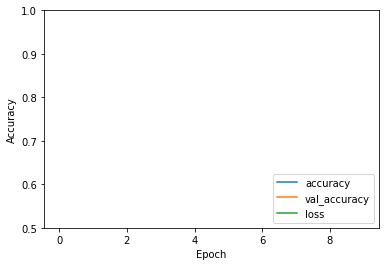

In [220]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

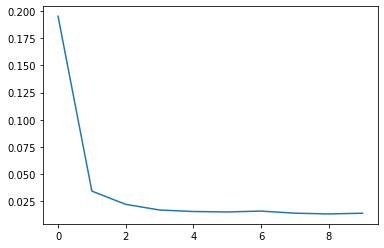

In [221]:
plt.plot(history.history['loss'], label = 'loss')